# Initial Setup - import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

In [2]:
# Create data directory if not exists
os.makedirs('../data', exist_ok=True)

# Load data
df = pd.read_csv('./data/sierraleone-bumbuna.csv', parse_dates=['Timestamp'])

# Data Profiling

In [3]:
print("=== Dataset Shape ===")
print(df.shape)

print("\n=== Data Types ===")
print(df.dtypes)

print("\n=== Summary Statistics ===")
print(df.describe(include='all'))

print("\n=== Missing Value Report ===")
missing = df.isna().sum()
missing_pct = (missing / len(df)) * 100
missing_report = pd.concat([missing, missing_pct], axis=1, keys=['Count', 'Percentage'])
print(missing_report[missing_report['Count'] > 0])

high_missing = missing_report[missing_report['Percentage'] > 5]
print("\n=== Columns with >5% Missing Values ===")
print(high_missing)

=== Dataset Shape ===
(525600, 19)

=== Data Types ===
Timestamp        datetime64[ns]
GHI                     float64
DNI                     float64
DHI                     float64
ModA                    float64
ModB                    float64
Tamb                    float64
RH                      float64
WS                      float64
WSgust                  float64
WSstdev                 float64
WD                      float64
WDstdev                 float64
BP                        int64
Cleaning                  int64
Precipitation           float64
TModA                   float64
TModB                   float64
Comments                float64
dtype: object

=== Summary Statistics ===
                           Timestamp            GHI            DNI  \
count                         525600  525600.000000  525600.000000   
mean   2022-04-30 12:00:30.000000768     201.957515     116.376337   
min              2021-10-30 00:01:00     -19.500000      -7.800000   
25%            

# Data Cleaning

In [4]:
# Handle negative radiation values
radiation_cols = ['GHI', 'DNI', 'DHI']
df[radiation_cols] = df[radiation_cols].clip(lower=0)

# Outlier detection using Z-scores
outlier_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = np.abs(stats.zscore(df[outlier_cols]))
outliers = (z_scores > 3).any(axis=1)

print(f"Identified {outliers.sum()} outlier rows ({outliers.mean()*100:.2f}%)")

# Create cleaned dataframe
df_clean = df[~outliers].copy()

# Impute missing values
for col in outlier_cols:
    if df_clean[col].isna().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

# Save cleaned data
df_clean.to_csv('./data/sierraleone_clean.csv', index=False)
print("Saved cleaned data to ./data/sierraleone-bumbuna.csv")

Identified 16547 outlier rows (3.15%)
Saved cleaned data to ./data/sierraleone-bumbuna.csv


# Time Series Analysis

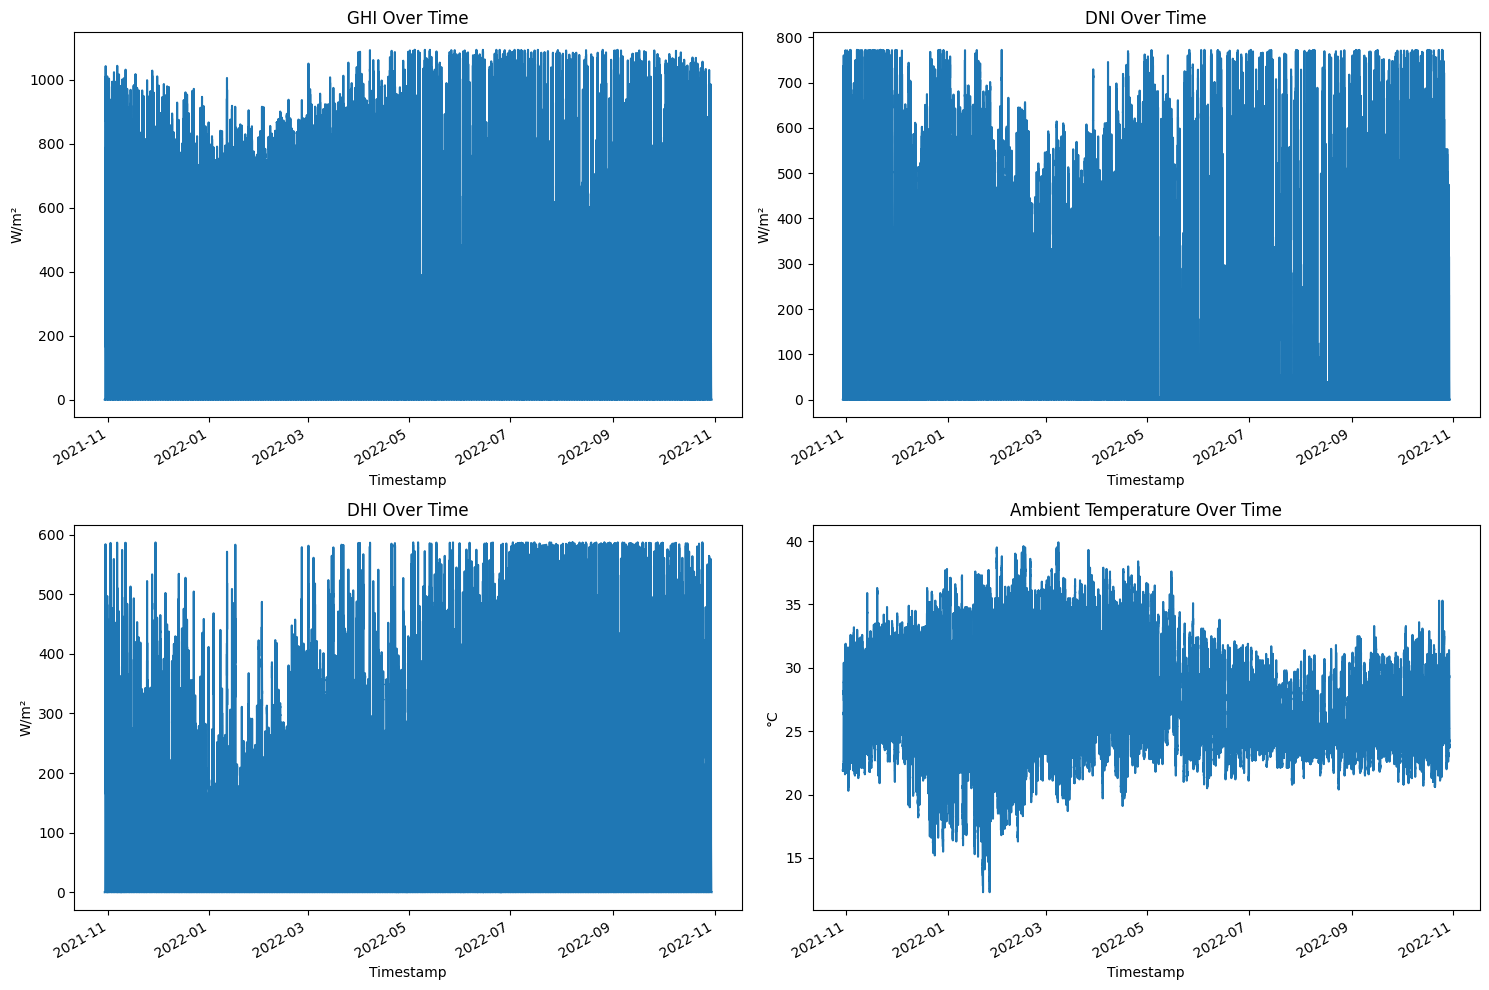

In [5]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
df_clean.set_index('Timestamp')['GHI'].plot(title='GHI Over Time')
plt.ylabel('W/m²')

plt.subplot(2, 2, 2)
df_clean.set_index('Timestamp')['DNI'].plot(title='DNI Over Time')
plt.ylabel('W/m²')

plt.subplot(2, 2, 3)
df_clean.set_index('Timestamp')['DHI'].plot(title='DHI Over Time')
plt.ylabel('W/m²')

plt.subplot(2, 2, 4)
df_clean.set_index('Timestamp')['Tamb'].plot(title='Ambient Temperature Over Time')
plt.ylabel('°C')

plt.tight_layout()
plt.show()

# Cleaning Impact Analysis

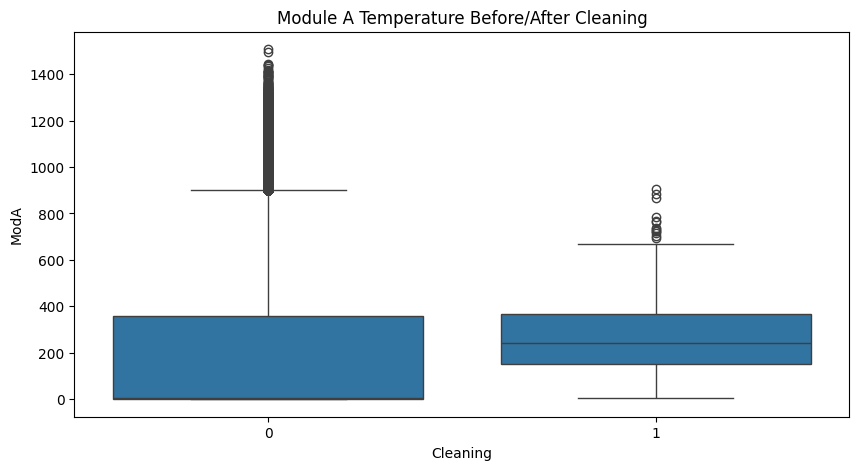

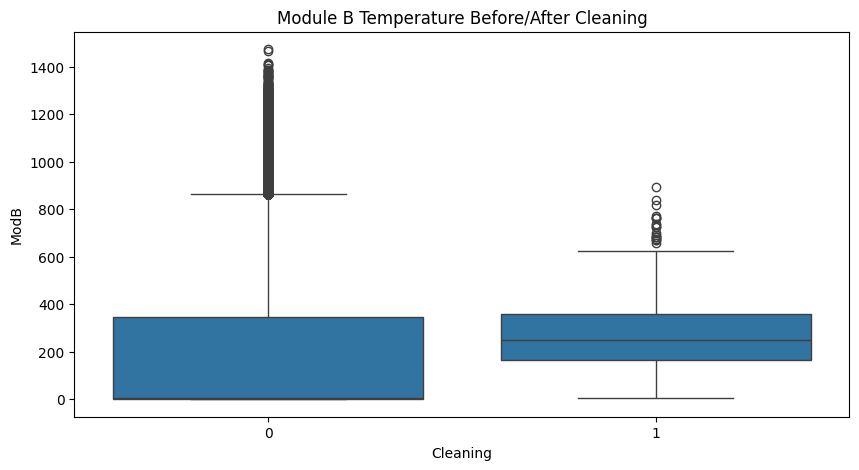

In [6]:
if 'Cleaning' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x='Cleaning', y='ModA')
    plt.title('Module A Temperature Before/After Cleaning')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x='Cleaning', y='ModB')
    plt.title('Module B Temperature Before/After Cleaning')
    plt.show()
else:
    print("No cleaning data available")

# Correlation Analysis

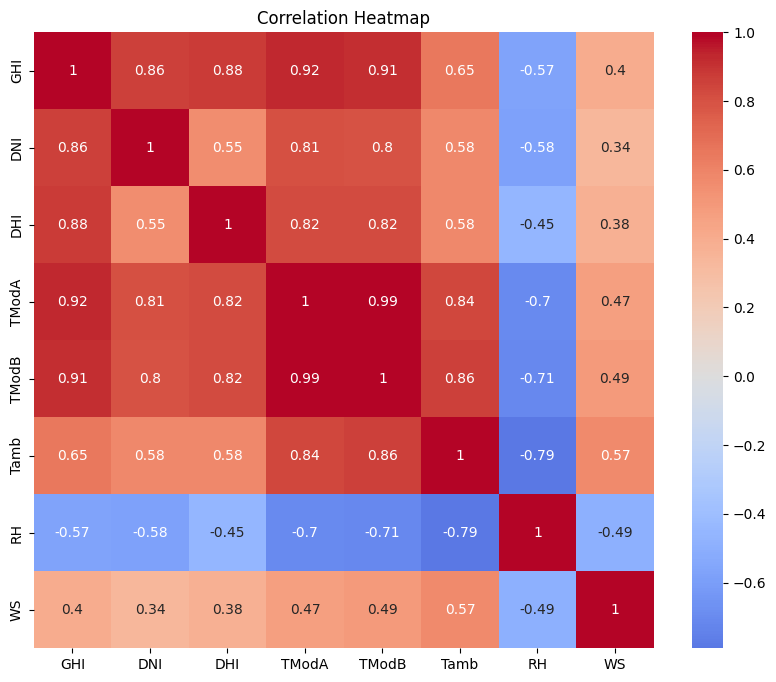

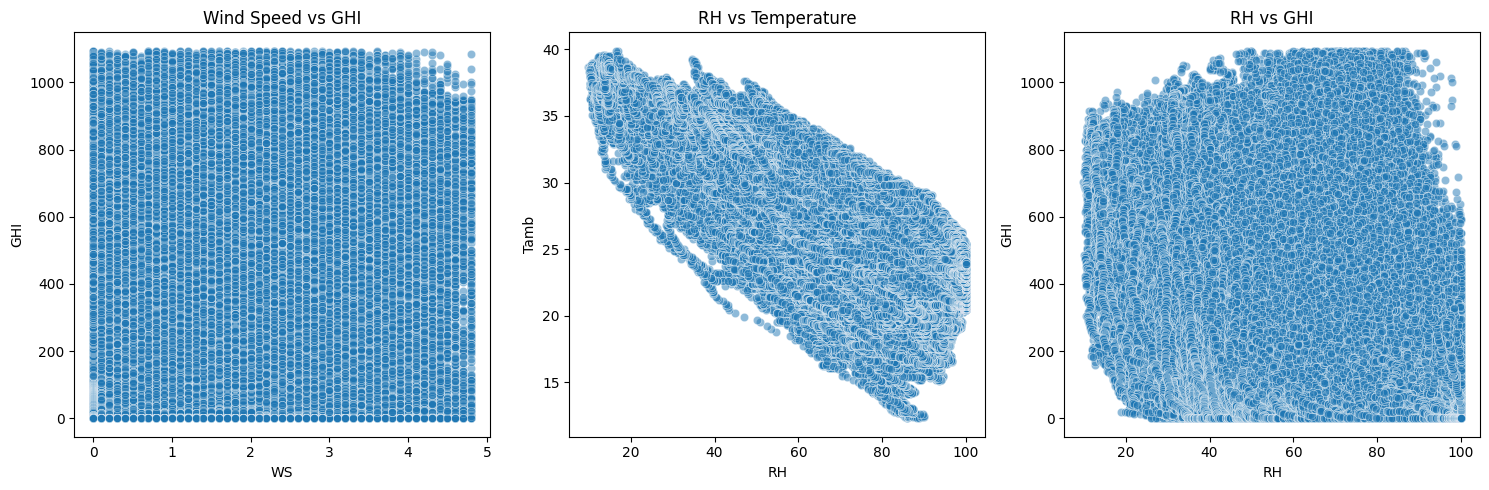

In [7]:
# Heatmap
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'Tamb', 'RH', 'WS']
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean[corr_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

# Scatter plots
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(data=df_clean, x='WS', y='GHI', alpha=0.5)
plt.title('Wind Speed vs GHI')

plt.subplot(1, 3, 2)
sns.scatterplot(data=df_clean, x='RH', y='Tamb', alpha=0.5)
plt.title('RH vs Temperature')

plt.subplot(1, 3, 3)
sns.scatterplot(data=df_clean, x='RH', y='GHI', alpha=0.5)
plt.title('RH vs GHI')

plt.tight_layout()
plt.show()

# Wind Analysis

Windrose package not installed. Install with: pip install windrose


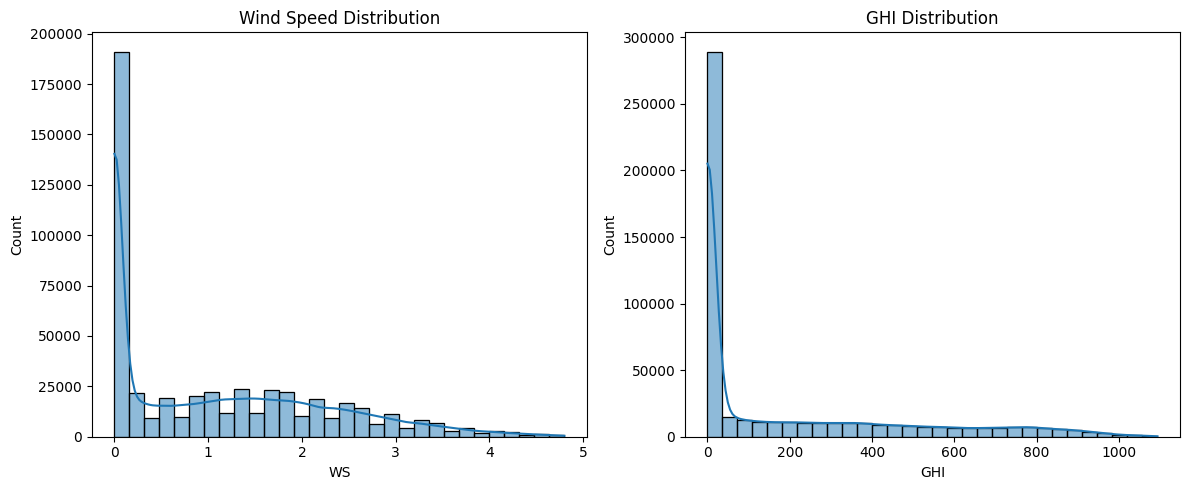

In [9]:
# Wind Rose (requires windrose package)
try:
    from windrose import WindroseAxes
    ax = WindroseAxes.from_ax()
    ax.bar(df_clean['WD'], df_clean['WS'], normed=True, opening=0.8, edgecolor='white')
    ax.set_legend()
    plt.title('Wind Rose')
    plt.show()
except ImportError:
    print("Windrose package not installed. Install with: pip install windrose")

# Distribution plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_clean['WS'], bins=30, kde=True)
plt.title('Wind Speed Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df_clean['GHI'], bins=30, kde=True)
plt.title('GHI Distribution')

plt.tight_layout()
plt.show()

# Temperature Analysis

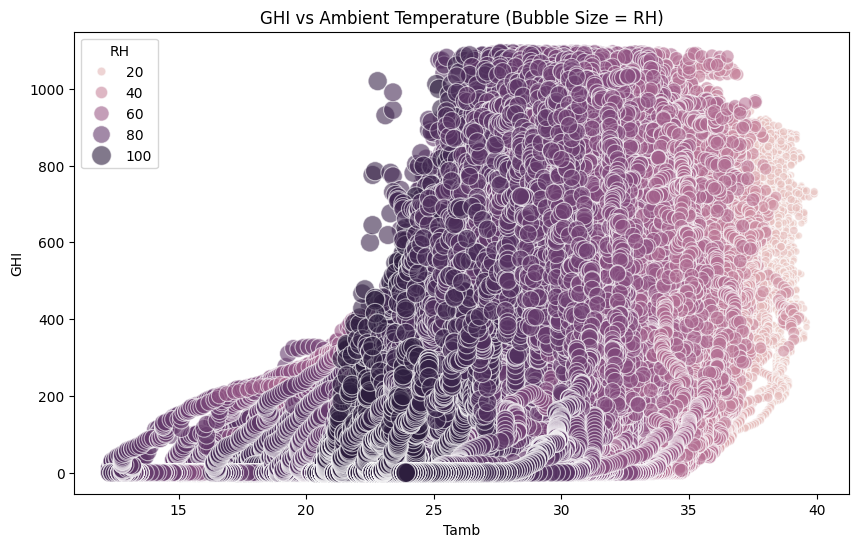

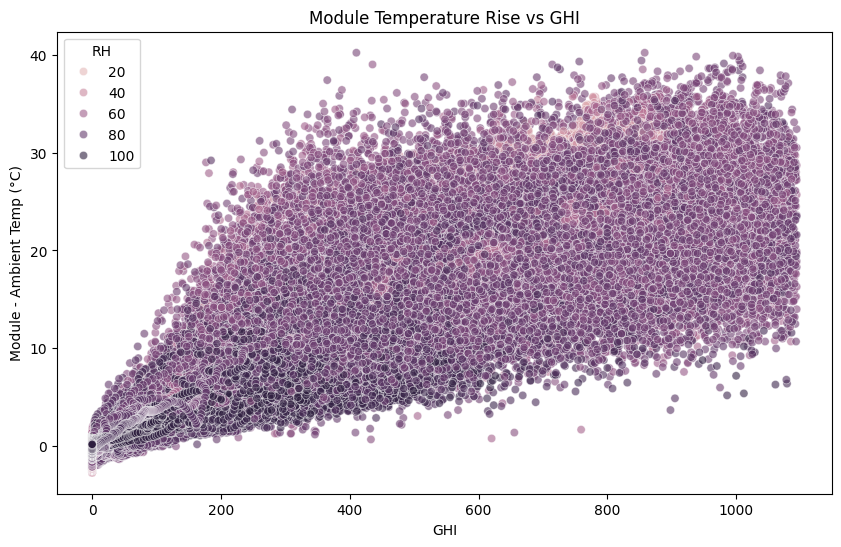

In [10]:
# Bubble chart
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='Tamb', y='GHI', size='RH', hue='RH', 
                sizes=(20, 200), alpha=0.6)
plt.title('GHI vs Ambient Temperature (Bubble Size = RH)')
plt.show()

# Temperature differential analysis
df_clean['Temp_Diff'] = df_clean['TModA'] - df_clean['Tamb']
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='GHI', y='Temp_Diff', hue='RH', alpha=0.6)
plt.title('Module Temperature Rise vs GHI')
plt.ylabel('Module - Ambient Temp (°C)')
plt.show()

# Key Performance Indicators

In [11]:
# Calculate KPIs
kpis = {
    'Average GHI (W/m²)': df_clean['GHI'].mean(),
    'Peak GHI (W/m²)': df_clean['GHI'].max(),
    'Average DNI (W/m²)': df_clean['DNI'].mean(),
    'Average DHI (W/m²)': df_clean['DHI'].mean(),
    'Average Module Temp (°C)': df_clean['TModA'].mean(),
    'Temperature Differential (°C)': df_clean['Temp_Diff'].mean(),
    'Clearness Index': (df_clean['DNI'] / (df_clean['GHI'] + 1e-6)).mean(),
    'Wind Speed (m/s)': df_clean['WS'].mean()
}

print("=== Key Performance Indicators ===")
for k, v in kpis.items():
    print(f"{k}: {v:.2f}")

=== Key Performance Indicators ===
Average GHI (W/m²): 187.21
Peak GHI (W/m²): 1094.00
Average DNI (W/m²): 104.21
Average DHI (W/m²): 110.50
Average Module Temp (°C): 31.95
Temperature Differential (°C): 5.74
Clearness Index: 790.70
Wind Speed (m/s): 1.09
